# BirdCLEF 2023 - Model Fitting 1

The goal here is to apply the guidelines and approach presented in the [First Steps, Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series of notebooks. Following that series, we'll look to use FastAI/PyTorch to create an effective validation set and iterate rapidly!

To overall plan is to start with transfer learning to train CNNs on spectrograms.

This notebook focuses transfer learning to train CNNs on spectrograms.

## Competition
https://www.kaggle.com/competitions/birdclef-2023

## Inputs
Original Ogg files with noise removed, downsampled, and resized to 30s.

<!-- | Notebook | Version |
| :-------- | :-----: |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-eda-part-1 | 3 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-eda-part-2 | 2 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-data-prep | 3 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-data-prep-partition | 2 |
 -->

# Setup
## Kaggle

In [1]:
from fastkaggle import setup_comp, iskaggle

comp  = 'birdclef-2023'
comp_path = setup_comp(comp, install='fastai timm fastaudio')
comp_path.ls()
# if iskaggle:
#     !pip install -q neptune-client neptune-fastai

(#7) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep-1')]

## Imports

In [2]:
from fastai.vision.all import *
import torch
import timm
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from fastaudio.core.all import *
from fastaudio.augment.all import *

from pathlib import Path
import time
import pickle
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

print(torch.__version__)

/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


2.0.0+cu117


In [3]:
assert torch.cuda.is_available(), 'Cuda is not available!'

# Config

In [4]:
wandb_on = True
wandb_project = 'birdclef-2023'
neptune_on = False
neptune_project = f'sdhca/{wandb_project}'

trn_path = comp_path/'train_audio_prep-2'
lr_find_on = True
# max_images = 1024  # for debugging. Set to None to use all
max_images = None

## Hyperparameters

In [5]:
hypp = dict(
    n_fft=512,
    batch_size=16,
    n_epochs=10,
    # nn_arch='mixnet_s',
    nn_arch='efficientnet_b0',
    freeze_epochs=1,
    # head_lr = 5e-3,
    base_lr = 5e-3,
    approach='Vanilla',
    to_fp16 = True
)

In [6]:
hypp

{'n_fft': 512,
 'batch_size': 16,
 'n_epochs': 10,
 'nn_arch': 'efficientnet_b0',
 'freeze_epochs': 1,
 'base_lr': 0.005,
 'approach': 'Vanilla',
 'to_fp16': True}

## Neptune

In [7]:
%load_ext dotenv
if iskaggle:
    %dotenv /kaggle/input/neptune-dotenv/.env
else:
    %dotenv

cannot find .env file


In [8]:
wandb_run = None
if wandb_on:
    import wandb
    from fastai.callback.wandb import *
    wandb.init(project=wandb_project, config=hypp)
    wandb_callback = WandbCallback(log_preds=False)

neptune_run = None
if neptune_on:
    import neptune.new as neptune 
    from neptune.new.integrations.fastai import NeptuneCallback
    neptune_run = neptune.init_run(project=neptune_project)
    neptune_run['parameters']=hypp
    neptune_callback = NeptuneCallback(run=neptune_run)
    neptune_run['Notes'] = ''

wandb: Currently logged in as: sdhca. Use `wandb login --relogin` to force relogin


# Model Selection

Useful resources:
 * https://timm.fast.ai/
 * https://huggingface.co/docs/timm/results
 * https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
 * https://towardsdatascience.com/does-imagenet-pretraining-work-for-chest-radiography-images-covid-19-2e2d9f5f0875
 * https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055
 
 Let's start with `mixnet_s` for fast iteration because it has only 4 M parameters.

In [9]:
timm.list_models('mixnet*', pretrained=True)

['mixnet_l', 'mixnet_m', 'mixnet_s', 'mixnet_xl']

In [10]:
# timm.list_models('*efficient*', pretrained=True)

In [11]:
# model = timm.create_model(hypp['nn_arch'], pretrained=True, num_classes=2, in_chans=3)
model, model_cfg = create_timm_model(hypp['nn_arch'], n_out=264, pretrained=True, n_in=1)
model_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'architecture': 'efficientnet_b0'}

In [12]:
img_size = model_cfg['input_size'][1]
img_size

224

In [13]:
del(model)

# Splits & DataLoaders

In [14]:
comp_path.ls()

(#7) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep-1')]

In [15]:
trn_df = pd.read_csv(comp_path/'train_metadata.csv')
if max_images:
    trn_df = trn_df.head(n=max_images)
trn_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


## Double-Up Classes with One Instance

In [16]:
solitary_labels = trn_df.pivot_table('filename', 'primary_label', aggfunc='count').query('filename==1').index.to_list()
solitary_labels

['afpkin1', 'brtcha1', 'crefra2', 'lotcor1', 'whctur2', 'whhsaw1', 'yebsto1']

In [17]:
solitary_df = trn_df[trn_df.primary_label.isin(solitary_labels)]
trn_df = pd.concat([trn_df, solitary_df])

## Train-Test Split
With 5 splits, we can just take the last pair of train and test indices to have an 80:20 train:test split.

In [18]:
# skf = StratifiedKFold(n_splits=5)
# splits = skf.split(trn_df, trn_df.primary_label)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
splits = sss.split(trn_df, trn_df.primary_label)

for trn_idx, tst_idx in splits:
    print(len(trn_idx), len(tst_idx), len(trn_idx) + len(tst_idx))

15253 1695 16948


## DataBlock

In [19]:
def _get_label(df, label_col):
    return df[label_col]

get_label = partial(_get_label, label_col='primary_label')

In [20]:
# cfg = AudioConfig.BasicMelSpectrogram(n_fft=hypp['n_fft'])
# a2s = AudioToSpec.from_cfg(cfg)
# batch_tfms = [a2s]

In [21]:
cfg = AudioConfig.BasicSpectrogram()
a2s = AudioToSpec.from_cfg(cfg)
batch_tfms = [a2s]

In [22]:
db = DataBlock(blocks=(AudioBlock, CategoryBlock),
               get_x=ColReader('filename', pref=trn_path),
               get_y=get_label,
               splitter=IndexSplitter(tst_idx),
               batch_tfms = batch_tfms)

In [23]:
# db.summary(trn_df)

## DataLoaders

In [24]:
# class_counts = pd.value_counts(train_df.cancer)
# class_wt_dict = dict(1 / class_counts)
# class_wt_dict

In [25]:
# class_wts = train_df.cancer.map(class_wt_dict).values
# class_wts

In [26]:
# dls = db.weighted_dataloaders(train_df, bs=hypp['batch_size'], num_workers=8, pin_memory=True, drop_last=True, wgts=class_wts)

In [27]:
dls = db.dataloaders(trn_df, bs=hypp['batch_size'], num_workers=8, pin_memory=True, drop_last=True)

### Show Batch

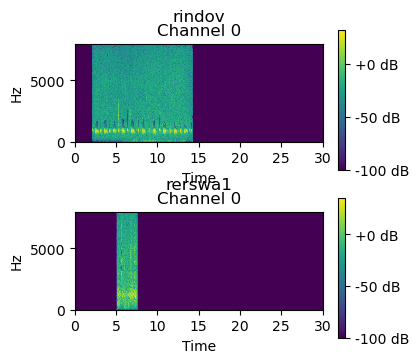

In [28]:
dls.show_batch(max_n=10)

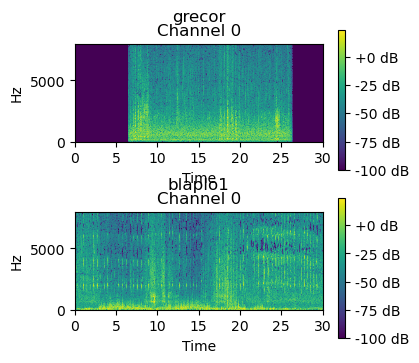

In [29]:
dls.show_batch(max_n=10)

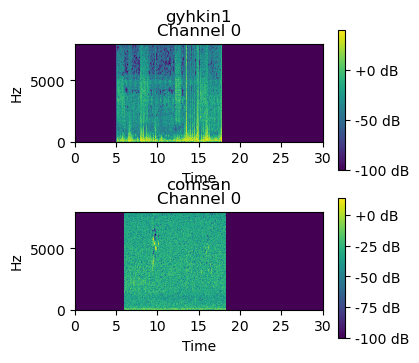

In [30]:
dls.show_batch(max_n=10)

# Metrics

## Probabilistic F1
https://www.kaggle.com/code/sohier/probabilistic-f-score

In [31]:
def pfbeta(preds, labels, beta, softmax=None, sigmoid=None):
    # print(f'softmax: {softmax}')
    # print(f'preds: {preds}')
    # print(f'true: {labels}')
    
    probs = preds
    if softmax:
        probs = torch.nn.Softmax(dim=1)(preds)
    elif sigmoid:
        probs = torch.nn.Sigmoid()(preds)
    # print(f'probs: {probs}')
    predictions = probs[:, -1]
    
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    if y_true_count == 0:
        return -1
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0
        
pF1 = partial(pfbeta, beta=1)

# print(pF1([1, 0, 1], [1, 0, 1]))
# print(pF1([0, 1, 0], [1, 0, 1]))
# print(pF1([0.5, 0.5, 0.5], [1, 0, 1]))
# print(pF1([0.5, 0, 0.5], [1, 0, 1]))

In [32]:
# pF1Score = AccumMetric(pF1, softmax=True, name='pF1', invert_arg=True, to_np=True)
# pF1Score = AccumMetric(pF1, name='pF1', invert_arg=False, to_np=False, flatten=False, softmax=True)  # For CrossEntropyLoss
# pF1Score = AccumMetric(pF1, name='pF1', invert_arg=False, to_np=False, flatten=False, sigmoid=True)  # For  BCELoss

## plot_metrics

In [33]:
# https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# Train Model

In [34]:
hypp

{'n_fft': 512,
 'batch_size': 16,
 'n_epochs': 10,
 'nn_arch': 'efficientnet_b0',
 'freeze_epochs': 1,
 'base_lr': 0.005,
 'approach': 'Vanilla',
 'to_fp16': True}

## Create Learner

In [35]:
learn = vision_learner(dls, hypp['nn_arch'], n_in=1, n_out=264, path='.')
# learn = vision_learner(dls, model, metrics=[F1Score(), pF1Score])
# learn = vision_learner(dls, hypp['nn_arch'], metrics=[F1Score(), pF1Score])
# learn = vision_learner(dls, hypp['nn_arch'], metrics=[F1Score(), pF1Score, accuracy], n_out=1, loss_func=BCEWithLogitsLossFlat())

if hypp['to_fp16']:
    print('Switching to mixed precision')
    learn = learn.to_fp16()

# # Don't want to capture LR find, so will add callbacks later
# if wandb_on:
#     print('Adding wandb.ai callback')
#     learn.add_cb(wandb_callback)

# if neptune_on:
#     print('Adding neptune.ai callback')
#     learn.add_cb(neptune_callback)

Switching to mixed precision


In [36]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [37]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

In [38]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, MixedPrecision, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor, MixedPrecision]
         - after_pred     : [MixedPrecision]
         - after_loss     : [MixedPrecision]
         - before_backward: [MixedPrecision]
         - before_step    : [MixedPrecision]
         - after_step     : [MixedPrecision]
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - a

In [39]:
L(dls.vocab)

(#264) ['abethr1','abhori1','abythr1','afbfly1','afdfly1','afecuc1','affeag1','afgfly1','afghor1','afmdov1'...]

In [40]:
assert len(dls.vocab) == 264, 'Some classes are not in the training set!'

## LR Find - Head

In [41]:
# learn.freeze()

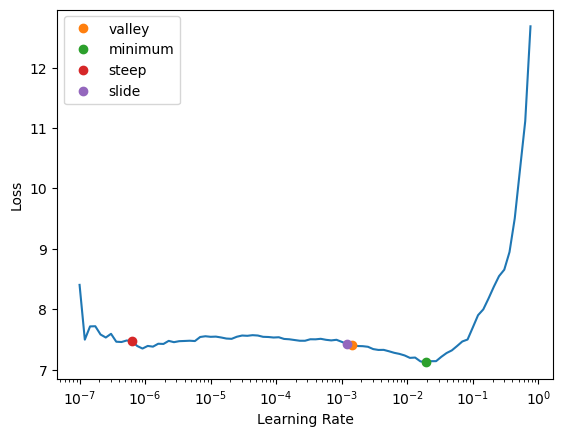

In [42]:
%%capture --no-stdout --no-display
if lr_find_on:
    learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

In [43]:
# if lr_find_on:
#     learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

## Fine Tune

In [44]:
if wandb_on:
    print('Adding wandb.ai callback')
    learn.add_cb(wandb_callback)

if neptune_on:
    print('Adding neptune.ai callback')
    learn.add_cb(neptune_callback)

Adding wandb.ai callback


In [45]:
%%capture --no-stdout --no-display
learn.fine_tune(hypp['n_epochs'],
                freeze_epochs=hypp['freeze_epochs'], 
                base_lr=hypp['base_lr'])

epoch,train_loss,valid_loss,time
0,4.552112,3.750105,04:16


epoch,train_loss,valid_loss,time
0,3.236717,2.849021,05:05
1,2.827921,2.448516,05:04
2,2.491609,2.154441,05:01
3,2.128197,1.895784,04:58
4,1.837241,1.717220,05:00
5,1.569137,1.643231,04:58
6,1.280842,1.570714,04:59
7,1.042193,1.523782,05:03
8,0.917451,1.540224,04:59
9,0.758108,1.519399,04:56


## Fine Tune - Head

In [46]:
# learn.freeze()

In [47]:
# learn.fit_one_cycle(n_epoch=hypp['freeze_epochs'], lr_max=hypp['head_lr'])

## LR Find - Full

In [48]:
# learn.unfreeze()

In [49]:
# if lr_find_on:
#     learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

In [50]:
# if lr_find_on:
#     learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

## Fine Tune - Full

In [51]:
# learn.unfreeze()

In [52]:
# learn.fit_one_cycle(n_epoch=hypp['n_epochs'], lr_max=hypp['base_lr'])

In [53]:
# learn.recorder.plot_metrics()

In [54]:
if neptune_on:
    neptune_run['final_pf1'] = learn.recorder.metrics[1].value.item()

## Check Results

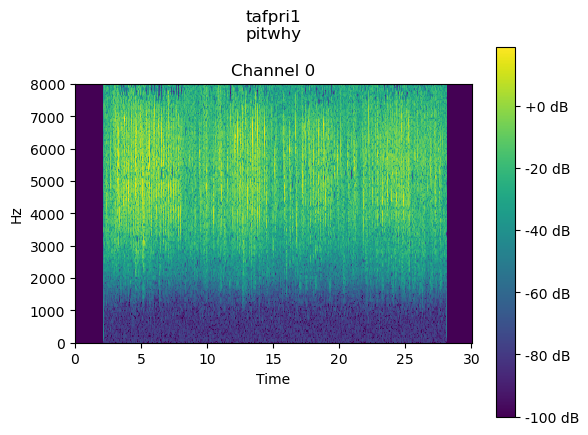

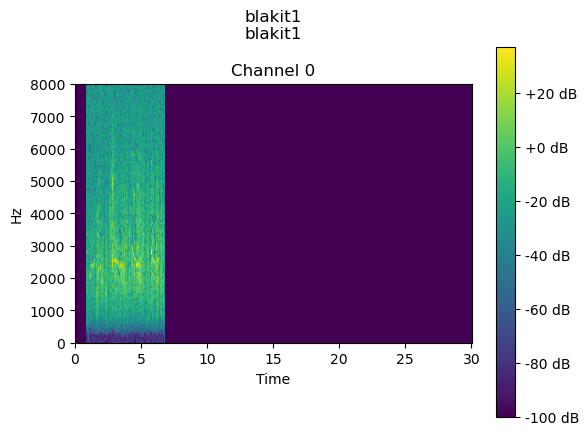

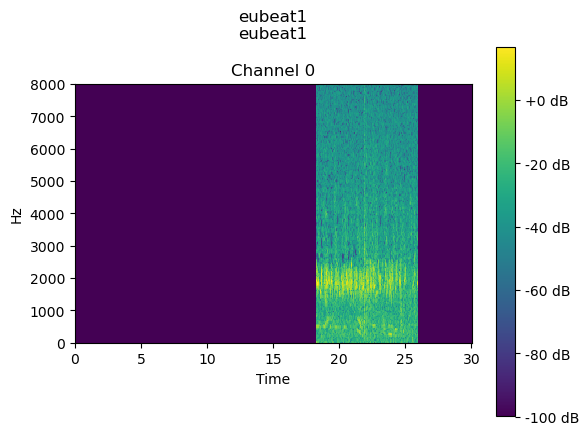

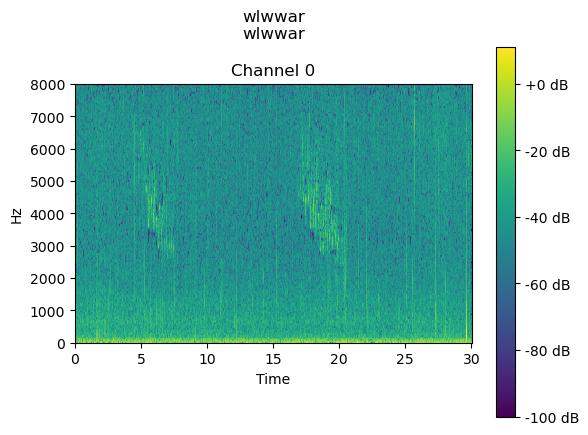

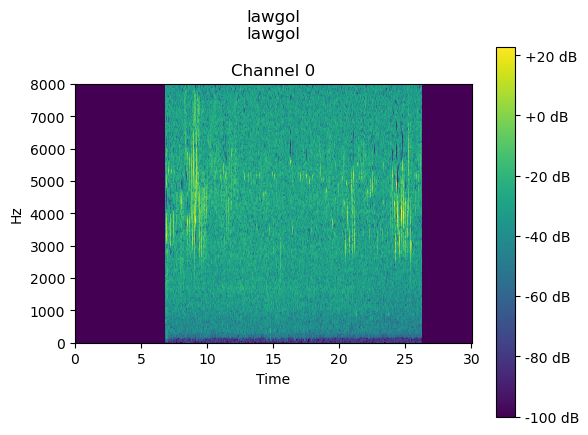

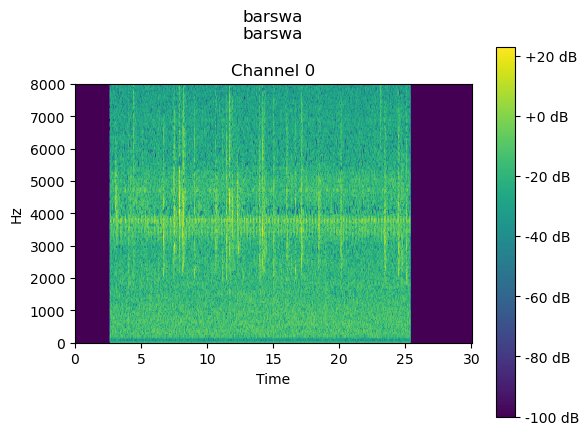

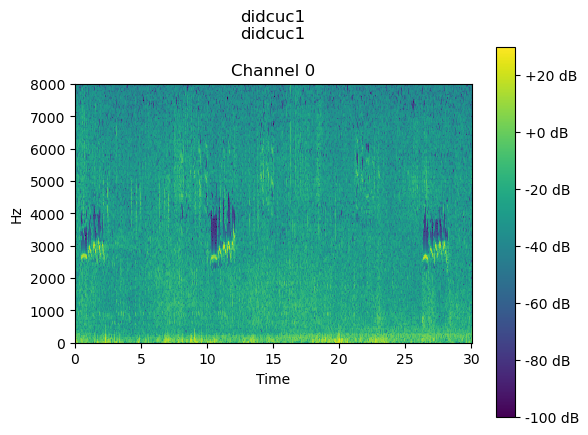

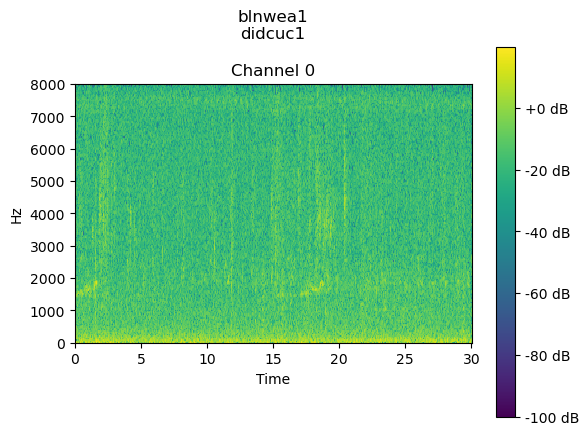

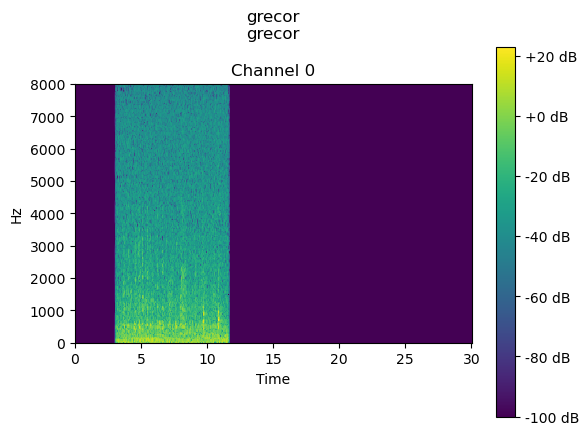

In [55]:
learn.show_results()

# Interpretation

In [56]:
warnings.filterwarnings?

Signature:
warnings.filterwarnings(
    action,
    message='',
    category=<class 'Warning'>,
    module='',
    lineno=0,
    append=False,
)
Docstring:
Insert an entry into the list of warnings filters (at the front).

'action' -- one of "error", "ignore", "always", "default", "module",
            or "once"
'message' -- a regex that the warning message must match
'category' -- a class that the warning must be a subclass of
'module' -- a regex that the module name must match
'lineno' -- an integer line number, 0 matches all warnings
'append' -- if true, append to the list of filters
File:      ~/mambaforge/envs/fastai/lib/python3.9/warnings.py
Type:      function


In [57]:
interp = ClassificationInterpretation.from_learner(learn)

In [58]:
# interp.plot_top_losses(9)

In [59]:
# interp.plot_confusion_matrix()

In [60]:
# interp.most_confused()

# Full Validation Assessment

In [61]:
comp_path.ls()

(#7) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep-1')]

In [62]:
tst_df = trn_df.loc[tst_idx]

In [63]:
tst_dl = learn.dls.test_dl(tst_df)

In [64]:
probs, _, idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [65]:
probs.shape

torch.Size([1695, 264])

In [66]:
idxs.shape

torch.Size([1695])

In [67]:
sub_sample_df = pd.read_csv(comp_path/'sample_submission.csv')
sub_sample_df.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
preds = (probs > 0.5).int()

In [69]:
preds[0]

TensorBase([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [70]:
sub_df = pd.DataFrame(tst_df.reset_index().filename)
sub_df.columns = ['row_id']
sub_df = pd.concat([sub_df, pd.DataFrame(preds, columns=learn.dls.vocab)], axis=1)
sub_df.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,hadibi1/XC431503.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,blakit1/XC511561.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,eaywag1/XC635441.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,quailf1/XC401970.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bcbeat1/XC713855.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
sub_df.describe()

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
count,1695.0,1695.000000,1695.0,1695.0,1695.000000,1695.000000,1695.00000,1695.0,1695.000000,1695.000000,...,1695.0,1695.0,1695.000000,1695.0,1695.0,1695.000000,1695.000000,1695.000000,1695.0,1695.000000
mean,0.0,0.009440,0.0,0.0,0.001770,0.005310,0.00118,0.0,0.003540,0.001770,...,0.0,0.0,0.005310,0.0,0.0,0.009440,0.000590,0.000590,0.0,0.005310
std,0.0,0.096726,0.0,0.0,0.042045,0.072696,0.03434,0.0,0.059409,0.042045,...,0.0,0.0,0.072696,0.0,0.0,0.096726,0.024289,0.024289,0.0,0.072696
min,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
max,0.0,1.000000,0.0,0.0,1.000000,1.000000,1.00000,0.0,1.000000,1.000000,...,0.0,0.0,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000


In [72]:
truth_df = sub_df.copy()
truth_df.iloc[:, 1:] = 0
truth_df.describe()

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
count,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,...,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0,1695.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
for r, c in enumerate(tst_df.primary_label):
    truth_df.loc[r, c] = 1
truth_df.describe()

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
count,1695.000000,1695.000000,1695.000000,1695.00000,1695.000000,1695.000000,1695.000000,1695.000000,1695.00000,1695.000000,...,1695.0,1695.000000,1695.000000,1695.00000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.00000
mean,0.000590,0.007670,0.001770,0.00118,0.001770,0.005310,0.002950,0.000590,0.00413,0.002360,...,0.0,0.000590,0.004720,0.00118,0.000590,0.007670,0.001770,0.000590,0.001770,0.00649
std,0.024289,0.087266,0.042045,0.03434,0.042045,0.072696,0.054248,0.024289,0.06415,0.048536,...,0.0,0.024289,0.068558,0.03434,0.024289,0.087266,0.042045,0.024289,0.042045,0.08032
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,0.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [74]:
# Function provided here: https://www.kaggle.com/competitions/birdclef-2023/overview/evaluation

import pandas as pd
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution.drop(['row_id'], axis=1, errors='ignore')
    submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

In [75]:
pcmap = padded_cmap(truth_df, sub_df)
print(pcmap)

0.7472483613974289


For comparison, what is the score when we predict all zeros or all ones?

In [76]:
sub_df.iloc[:, 1:] = 0
padded_cmap(truth_df, sub_df)

0.60406572840755

In [77]:
sub_df.iloc[:, 1:] = 1
padded_cmap(truth_df, sub_df)

0.0067179144385026745

# Export

In [78]:
timestr = time.strftime("%Y%m%d-%H%M%S")
model_fname = Path(f"birdclef-2023-{hypp['nn_arch']}-{timestr}.pkl")
if iskaggle:
    model_fname = Path('/kaggle/working')/model_fname
model_fname

Path('birdclef-2023-efficientnet_b0-20230320-232256.pkl')

In [79]:
if wandb_on:
    wandb.log({
        'model_fname': str(model_fname),
        'padded_cmap': pcmap
    })
    wandb.finish()
    learn.remove_cbs(wandb_callback)

if neptune_on:
    neptune_run['model_fname'] = model_fname
    neptune_run.stop()
    learn.remove_cbs(neptune_callback)

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▂▄▆█▂▂▂▂▃▃▄▄▄▄▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▆▃▁██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇▇████
mom_1,█▆▃▁██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇▇████
padded_cmap,▁
raw_loss,█▅▆▅▅▄▄▅▄▄▄▄▄▂▂▃▃▃▄▃▂▃▁▂▂▂▁▂▂▂▂▁▂▁▂▁▁▂▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [80]:
learn.export(model_fname)

In [81]:
# Also save the test indices associated with this model for separate experimentation with threholding / binarization to optimize pF1
split_fname = Path(str(model_fname.with_suffix('')) + '-test_indices').with_suffix('.pkl')
if iskaggle:
    split_fname = Path('/kaggle/working')/split_fname
    
with open(split_fname, 'wb') as fhandle:
    pickle.dump(tst_idx, fhandle)